In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# 1

In [2]:
means = np.linspace(1, 10, 3, dtype=float)
np.vstack(tuple(means for _ in range(10)))

array([[ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ],
       [ 1. ,  5.5, 10. ]])

In [3]:
class MultiArmedBandit:
    def __init__(self, K, T, means, stds):
        self.K = K
        self.T = T
        
        self.means = np.vstack(tuple(means for _ in range(T)))
        self.stds = np.vstack(tuple(stds for _ in range(T)))

        self.gains = np.random.normal(self.means, self.stds)

        self.attempt = 0

    def play(self, k):
        
        gain = self.gains[self.attempt, k]
        self.attempt += 1

        return gain

In [4]:
# class MultiArmedBandit:
#     def __init__(self, K, T, means, stds):
#         self.K = K
#         self.T = T
        
#         self.means = torch.cat(tuple(means.view(-1, 1) for _ in range(T)), 1)
#         self.stds = torch.cat(tuple(stds.view(-1, 1) for _ in range(T)), 1)

#         self.gains = torch.normal(self.means, self.stds)

#         self.attempt = 0

#     def play(self, k):
        
#         gain = self.gains[k, self.attempt]
#         self.attempt += 1

#         return gain

In [5]:
test_bandit = MultiArmedBandit(
    K=3, 
    T=10, 
    means=np.linspace(1, 10, 3, dtype=float),
    stds=np.ones(3, dtype=float) / 10
)

In [6]:
for i in range(10):
    print(test_bandit.play(i % 3))

0.7356430845885069
5.466266135233415
9.876910354497724
0.9050358943701731
5.531912621556287
9.781244694640193
1.0310078443270905
5.609599616145818
9.879413717519213
1.0112828490549413


In [7]:
class UCB:
    def __init__(self, K, c):
        self.K = K
        self.gains = np.zeros(K, dtype=float)
        self.attempts = np.zeros(K, dtype=int)
        self.t = 0
        self.c = c

    def play(self):
        if self.t < self.K:
            return self.t
        
        return np.argmax(
            self.gains / self.attempts + 
            self.c * np.sqrt(np.log(self.t) / self.attempts)
        )
    
    def get_gain(self, arm, gain):
        self.t += 1
        self.attempts[arm] += 1
        self.gains[arm] += gain


In [8]:
K = 3
T = 300

test_bandit = MultiArmedBandit(
    K=K, 
    T=T, 
    means=np.linspace(1, 10, K, dtype=float),
    stds=np.ones(K, dtype=float) * 3,
)

test_ucb = UCB(K, 5)

arms = []
gains = []

for _ in range(T):
    arm = test_ucb.play()
    gain = test_bandit.play(arm)
    test_ucb.get_gain(arm, gain)

    arms.append(arm)
    gains.append(gain)

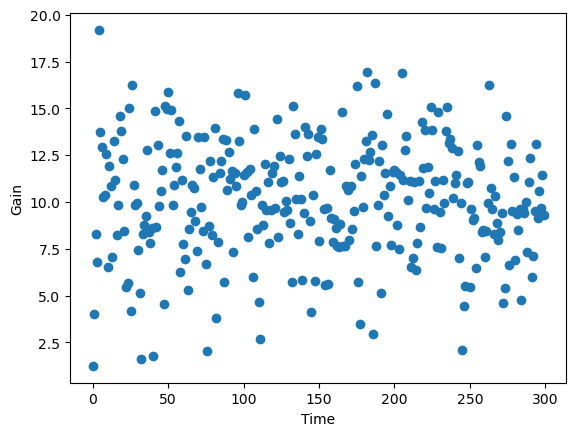

In [9]:
plt.scatter(np.arange(T), gains)
plt.xlabel('Time')
plt.ylabel('Gain')
plt.show()

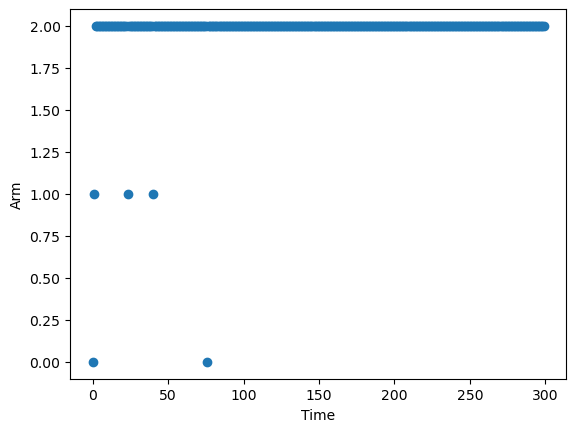

In [10]:
plt.scatter(np.arange(T), arms)
plt.xlabel('Time')
plt.ylabel('Arm')
plt.show()

In [11]:
class PhasedUCB:
    def __init__(self, K, c, get_round_length):
        self.K = K
        self.c = c
        self.get_round_length = get_round_length

        self.gains = np.zeros(K, dtype=float)
        self.attempts = np.zeros(K, dtype=int)
        self.t = 0

        self.round_num = 0
        self.round_length = get_round_length(self.round_num)
        self.t_round = 0

    def play(self):
        if self.t < self.K:
            self.arm = self.t
        
        elif self.t_round >= self.round_length:
            self.arm = np.argmax(
                self.gains / self.attempts + 
                self.c * np.sqrt(np.log(self.t) / self.attempts)
            )

            self.t_round = 0
            self.round_num += 1
            self.round_length = self.get_round_length(self.round_num)

        return self.arm, self.round_num
    
    def get_gain(self, arm, gain):
        self.t += 1
        self.t_round += 1

        self.attempts[arm] += 1
        self.gains[arm] += gain


In [12]:
K = 3
T = 300

test_bandit = MultiArmedBandit(
    K=K, 
    T=T, 
    means=np.linspace(1, 10, K, dtype=float),
    stds=np.ones(K, dtype=float) * 3,
)

test_ucb = PhasedUCB(K, 5, lambda n: 2 ** n)

arms = []
gains = []
rounds = []

for _ in range(T):
    arm, round = test_ucb.play()
    gain = test_bandit.play(arm)
    test_ucb.get_gain(arm, gain)

    arms.append(arm)
    gains.append(gain)
    rounds.append(round)

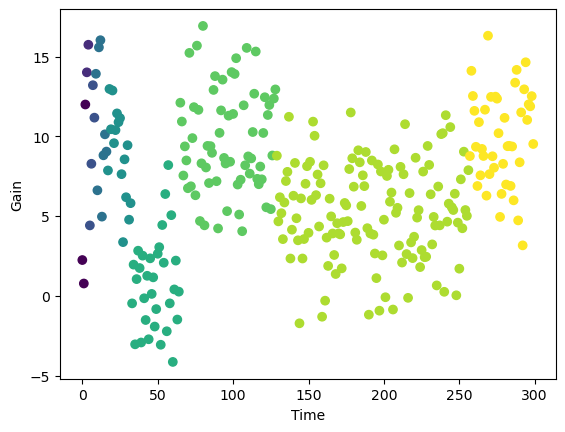

In [13]:
plt.scatter(np.arange(T), gains, c=rounds)
plt.xlabel('Time')
plt.ylabel('Gain')
plt.show()

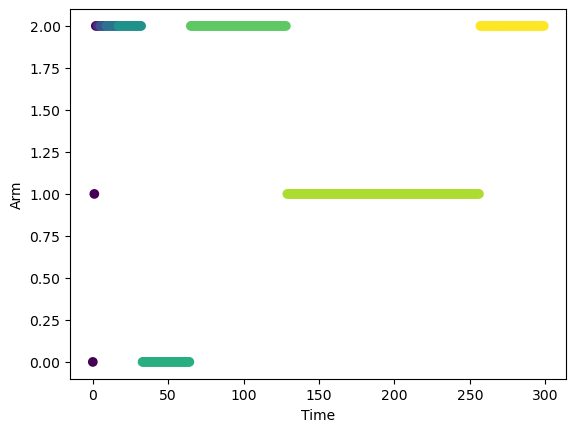

In [14]:

plt.scatter(np.arange(T), arms, c=rounds)
plt.xlabel('Time')
plt.ylabel('Arm')
plt.show()

In [15]:
class PhasedUCBII:
    def __init__(self, K, c, get_round_length):
        self.K = K
        self.c = c
        self.get_round_length = get_round_length

        self.gains = np.zeros(K, dtype=float)
        self.attempts = np.zeros(K, dtype=int)
        self.t = 0

        self.round_num = 0
        self.round_length = 1
        self.t_round = 0

    def play(self):
        if self.t < self.K:
            self.arm = self.t
        
        elif self.t_round >= self.round_length:
            self.arm = np.argmax(
                self.gains / self.attempts + 
                self.c * np.sqrt(np.log(self.t) / self.attempts)
            )

            self.t_round = 0
            self.round_num += 1
            self.round_length = self.get_round_length(self.attempts[arm])

        return self.arm, self.round_num
    
    def get_gain(self, arm, gain):
        self.t += 1
        self.t_round += 1

        self.attempts[arm] += 1
        self.gains[arm] += gain


In [16]:
K = 3
T = 300

test_bandit = MultiArmedBandit(
    K=K, 
    T=T, 
    means=np.linspace(1, 10, K, dtype=float),
    stds=np.ones(K, dtype=float) * 3,
)

a = 1.5
test_ucb = PhasedUCB(K, 5, lambda n: 2 * n)

arms = []
gains = []
rounds = []

for _ in range(T):
    arm, round = test_ucb.play()
    gain = test_bandit.play(arm)
    test_ucb.get_gain(arm, gain)

    arms.append(arm)
    gains.append(gain)
    rounds.append(round)


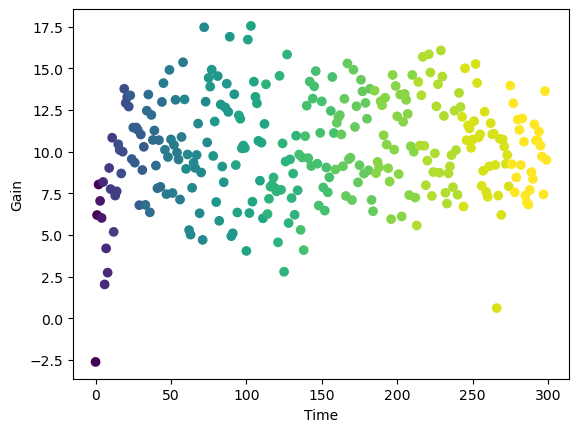

In [17]:
plt.scatter(np.arange(T), gains, c=rounds)
plt.xlabel('Time')
plt.ylabel('Gain')
plt.show()

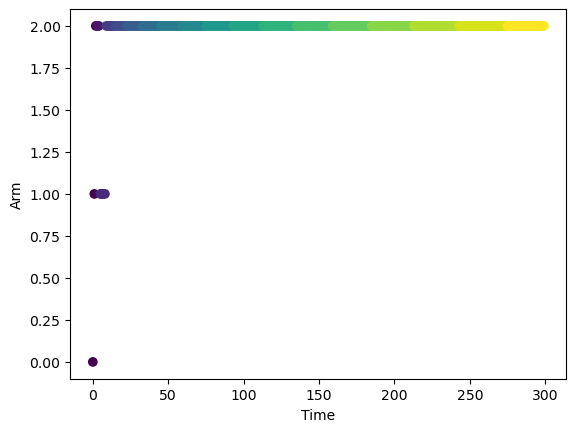

In [18]:
plt.scatter(np.arange(T), arms, c=rounds)
plt.xlabel('Time')
plt.ylabel('Arm')
plt.show()

# 2

## SVM

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [20]:
X, y = load_breast_cancer(return_X_y=True)
y = 2 * y - 1
X /= np.outer(np.ones(X.shape[0]),np.max(np.abs(X),0))

In [21]:
def logit(x):
    return 1 / (1 + np.exp(-x))

class SVM_OGD:
    def __init__(self, lr, n_features):
        self.lr = lr
        self.w = np.random.normal(size=n_features)

    
    def train_new_item(self, x, y):
        x = np.hstack([np.ones(1), x])
        grad = self.get_grad(x, y)
        self.w -= self.lr * grad

    def predict_proba(self, X):
        X = np.hstack([np.ones((len(X), 1)), X])
        return logit(X @ self.w)
            

    def get_grad(self, x, y):
        return -logit(-y * (x @ self.w)) * y * x



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
model = SVM_OGD(0.3, X_train.shape[1] + 1)

In [24]:
for x, y in zip(X_train, y_train):
    model.train_new_item(x, y)

In [25]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.9760649087221096

In [26]:
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.notebook import tqdm

In [27]:
transforms_simple = transforms.Compose([
    transforms.ToTensor(), 
])

In [28]:
train_data = MNIST(root='.', train=True, download=True, transform=transforms_simple)
test_data = MNIST(root='.', train=False, download=True, transform=transforms_simple)

In [29]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=1,
    shuffle=True,
)

In [30]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=True,
)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [45]:
model = Net()
loss_fn = nn.CrossEntropyLoss()

In [61]:
lr = 1
train_losses = []

model.train()

for x, y in tqdm(train_loader):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    for p in model.parameters():
        p.data -= lr * p.grad

    model.zero_grad()
    train_losses.append(loss.item())

  0%|          | 0/1875 [00:00<?, ?it/s]

In [62]:
model.eval()

losses = []
for X, y in test_loader:
    y_pred = model(X)
    losses.append(loss_fn(y_pred, y).item())

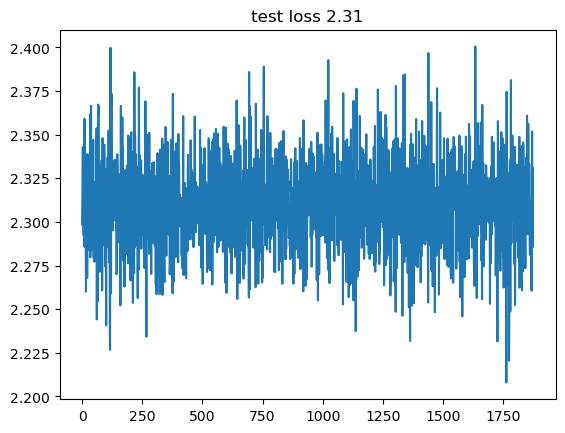

In [63]:
plt.title(f'test loss {np.mean(losses):.2f}')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.show()

In [64]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
)

In [65]:
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [66]:
model.train()
train_loss = []
for X, y in tqdm(train_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

model.eval()

losses = []
for X, y in test_loader:
    y_pred = model(X)
    losses.append(loss_fn(y_pred, y).item())

  0%|          | 0/1875 [00:00<?, ?it/s]

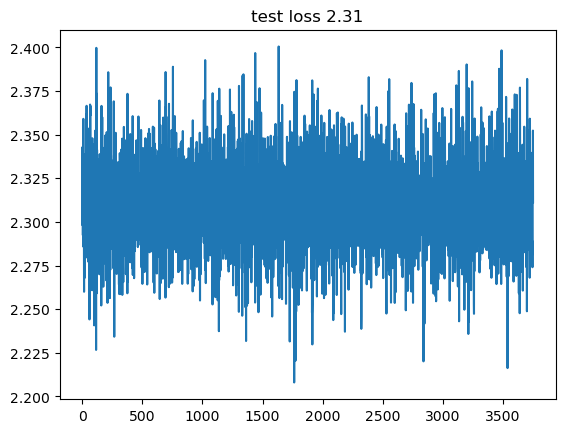

In [67]:
plt.title(f'test loss {np.mean(losses):.2f}')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.show()